In [76]:
# 패키지 import 하기
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import ShuffleSplit, train_test_split

import seaborn as sns
from matplotlib import pyplot as plt

# 그래프를 인라인으로 표시
%matplotlib inline

# housing data 불러오기
# 'RM', 'LSTAT', 'PTRATIO', 'MEDV'는 필수적인 특징이라고 판단했음, 나머지 관련 없는 특징은 제외됨.
data = pd.read_csv('./data/housing.csv')

# 'MEDV' 값이 50.0인 16개의 데이터 포인트는 누락되거나 검열된 값을 포함할 가능성이 높으므로 제거됨
prices = data['MEDV']
features = data.drop('MEDV', axis = 1)
    
# Success
print("Boston housing dataset has {} data points with {} variables each.".format(*data.shape))

Boston housing dataset has 489 data points with 4 variables each.


In [77]:
# data type 과 결측치 확인하기
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 489 entries, 0 to 488
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   RM       489 non-null    float64
 1   LSTAT    489 non-null    float64
 2   PTRATIO  489 non-null    float64
 3   MEDV     489 non-null    float64
dtypes: float64(4)
memory usage: 15.4 KB


In [78]:
# data 요약하기
data.describe()

,RM,LSTAT,PTRATIO,MEDV
count,489.000000,489.000000,489.000000,4.890000e+02
mean,6.240288,12.939632,18.516564,4.543429e+05
std,0.643650,7.081990,2.111268,1.653403e+05
min,3.561000,1.980000,12.600000,1.050000e+05
25%,5.880000,7.370000,17.400000,3.507000e+05
50%,6.185000,11.690000,19.100000,4.389000e+05
75%,6.575000,17.120000,20.200000,5.187000e+05
max,8.398000,37.970000,22.000000,1.024800e+06


## 시각화 코드

In [79]:
###########################################
# 경고 메세지 무시 설정
import warnings
warnings.filterwarnings("ignore", category = UserWarning, module = "matplotlib")

# Matplotlib 차트를 Jupyter Notebook 내에 직접 표시하도록 설정
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
###########################################

# 다양한 크기의 train data 로 여러 모델의 성능을 계산하고 시각화하는 함수
# X : train data(특징 행렬), y : 타겟 변수(레이블 벡터)
def ModelLearning(X, y):

    # ShuffleSplit 객체를 사용, 10개의 교차 검증 세트를 생성함
    # 데이터 전체의 20% 를 test data로 설정
    cv = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 0)
    cv.get_n_splits(X)

    # train size 는 train data 의 크기를 50개씩 증가시키면서 생성함 - 전체 데이터의 80%
    train_sizes = np.rint(np.linspace(1, X.shape[0]*0.8 - 1, 9)).astype(int)

    # 시각화 관련 설정
    fig = pl.figure(figsize=(10,7))

    # 결정 트리 회귀 모델을 생성한다
    for k, depth in enumerate([1,3,6,10]):
        
        # 최대 깊이가 1, 3, 6, 10 인 결정 트리 회귀 모델을 생성한다
        regressor = DecisionTreeRegressor(max_depth = depth)

        # learing_curve 함수를 사용 각 모델에 대해 훈련 데이터 크기별로 훈련 및 테스트 점수를 계산하게 한다.
        sizes, train_scores, test_scores = learning_curve(regressor, X, y, \
            cv = cv, train_sizes = train_sizes, scoring = 'r2')
        
        # 각 훈련 데이터 크기에 대한 평균 성능과 변동성을 계산하여 학습 곡선을 평탄화한다.
        # train/test 표준편차 계산 - 1차원 배열
        train_std = np.std(train_scores, axis = 1)
        test_std = np.std(test_scores, axis = 1)

        # train/test 평균 계산 - 1차원 배열
        train_mean = np.mean(train_scores, axis = 1)
        test_mean = np.mean(test_scores, axis = 1)

        # 서브 플롯을 생성, 각 모델별로 학습 곡선을 그린다.
        ax = fig.add_subplot(2, 2, k+1)

        # train/test 점수의 평균, 표준편차를 계산해 부드러운 곡선을 그려준다
        ax.plot(sizes, train_mean, 'o-', color = 'r', label = 'Training Score')
        ax.plot(sizes, test_mean, 'o-', color = 'g', label = 'Testing Score')

        # 쉐도우 영역을 채워 train/test 점수의 변동성을 시각적으로 나타내준다.
        ax.fill_between(sizes, train_mean - train_std, \
            train_mean + train_std, alpha = 0.15, color = 'r')
        ax.fill_between(sizes, test_mean - test_std, \
            test_mean + test_std, alpha = 0.15, color = 'g')
        
        # 레이블 및 축 설정
        ax.set_title('max_depth = %s'%(depth))
        ax.set_xlabel('Number of Training Points')
        ax.set_ylabel('Score')
        ax.set_xlim([0, X.shape[0]*0.8])
        ax.set_ylim([-0.05, 1.05])
    
    # 표로 시각화
    ax.legend(bbox_to_anchor=(1.05, 2.05), loc='lower left', borderaxespad = 0.)
    fig.suptitle('Decision Tree Regressor Learning Performances', fontsize = 16, y = 1.03)
    fig.tight_layout()
    fig.show()

## ModelLearning 함수는 결정 트리 회귀 모델의 학습 곡선을 시각화하여 훈련 데이터 크기가 모델 성능에 미치는 영향을 탐색하는데 도움

In [80]:
# 결정 트리 회귀 모델의 복잡성 (max_depth) 증가에 따른 성능 변화를 계산하고 시각화하는 함수
def ModelComplexity(X, y):

    # ShuffleSplit 객체를 사용, 10개의 교차 검증 세트를 생성함
    # 각 세트는 데이터 전체의 20%를 테스트 데이터로 사용합니다.
    cv = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 0)
    cv.get_n_splits(X)

    # 결정 트리의 최대 depth 값을 1부터 10까지 변화시키는 배열 - 모델 복잡성을 단계적으로 증가시키며 성능을 측정
    max_depth = np.arange(1,11)

    # validation_curve 함수를 사용하여 각 max_depth 값에 대해 train/test 점수를 계산합니다.
    train_scores, test_scores = validation_curve(DecisionTreeRegressor(), X, y, \
        param_name = "max_depth", param_range = max_depth, cv = cv, scoring = 'r2')

    # 학습 곡선 평활화와 동일한 방식으로 train/test 점수의 평균과 표준 편차를 계산
    # 평균 계산
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    # 표준편차 계산
    train_std = np.std(train_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # 복잡성 성능 곡선 그려 확인하기
    pl.figure(figsize=(7, 5))
    pl.title('Decision Tree Regressor Complexity Performance')

    # 최대 depth 값에 따른 train/test 점수의 평균을 선으로 그립니다.
    pl.plot(max_depth, train_mean, 'o-', color = 'r', label = 'Training Score')
    pl.plot(max_depth, test_mean, 'o-', color = 'g', label = 'Validation Score')

    # 쉐도우 영역을 채워 train/test 점수의 변동성을 시각적으로 나타냅니다.
    pl.fill_between(max_depth, train_mean - train_std, \
        train_mean + train_std, alpha = 0.15, color = 'r')
    pl.fill_between(max_depth, test_mean - test_std, \
        test_mean + test_std, alpha = 0.15, color = 'g')
    
    # 시각화 설정
    pl.legend(loc = 'lower right')
    pl.xlabel('Maximum Depth')
    pl.ylabel('Score')
    pl.ylim([-0.05,1.05])
    pl.show()

##  함수는 결정 트리 회귀 모델의 최대 depth 값을 조정하여 모델 복잡성이 성능에 미치는 영향을 시각적으로 분석하는데 도움

In [81]:
# PredictTrials 함수는 주어진 데이터에 대한 예측을 여러 번 시행하고 결과의 변동성을 분석

# X: 훈련 데이터 (특징 행렬)
# y: 타깃 변수 (레이블 벡터)
# fitter: 모델 fitting 함수 (여기서는 DecisionTreeRegressor)
# data: 예측하고자 하는 데이터 (1개의 샘플)
def PredictTrials(X, y, fitter, data):
 
    # 예측값 저장을 위한 리스트 생성
    prices = []

    # for 문을 사용 10번을 반복한다.
    for k in range(10):

        # 각 반복마다 train_test_split 를 사용 train/test 로 데이터를 분할함
        X_train, X_test, y_train, y_test = train_test_split(X, y, \
            test_size = 0.2, random_state = k)
        
        # 모델 fitting 을 실시 - 분할된 훈련 데이터를 이용하여 fitter 함수를 호출하여 모델을 fitting합니다.
        reg = fitter(X_train, y_train)
        
        # 예측 실시
        # 훈련된 모델 (결정 나무)을 이용하여 입력 데이터에 대한 예측 값을 계산
        # predict 메서드를 사용하여 예측을 수행하며, 결과는 pred 변수에 저장

        # 입력 데이터가 2차원 배열이므로 첫 번째 데이터만 추출, 예측을 수행하고 결과값을 반환
        pred = reg.predict([data[0]])[0]

        # 구한 값을 price에 저장한다.
        prices.append(pred)
        
        # 결과를 출력 - 통화 형식으로 표기
        print("Trial {}: ${:,.2f}".format(k+1, pred))

    # 리스트 prices에 저장한 후 최대값과 최소값의 차이를 계산하여 예측 값의 변동 범위를 출력
    print("\nRange in prices: ${:,.2f}".format(max(prices) - min(prices)))


## 함수는 랜덤 시드를 변경하여 여러 번의 예측을 수행함으로써 예측 결과의 신뢰성을 평가하는데 도움
## 예측 값의 변동성이 크다면 모델의 일반화 성능이 떨어질 가능성이 높으므로 모델 개선이나 하이퍼파라미터 튜닝을 고려해야 할 수 있습니다.

## 가격 예측 모델링 실시 전 데이터 통계 분석 및 분포 확인

* price 열의 최소, 최대, 평균, 중간, 표준 편차 값들을 구해 데이터 분포를 확인/분석한다

In [82]:
# housing 에서 최소 가격을 찾는다.
minimum_price = np.min(prices)

# housing 에서 최대 가격을 찾는다.
maximum_price = np.max(prices)

# housing 가격의 평균을 계산
mean_price = np.mean(prices)

# housing 가격의 중간값을 계산
median_price = np.median(prices)

# data 가격의 표준 편차를 구함
std_price = np.std(prices)

# 통계 계산 결과를 출력
print("Statistics for Boston housing dataset:\n")
print("최소값: ${:,.2f}".format(minimum_price))
print("최대값: ${:,.2f}".format(maximum_price))
print("평균값: ${:,.2f}".format(mean_price))
print("중간값 ${:,.2f}".format(median_price))
print("표준편차: ${:,.2f}".format(std_price))

Statistics for Boston housing dataset:

최소값: $105,000.00
최대값: $1,024,800.00
평균값: $454,342.94
중간값 $438,900.00
표준편차: $165,171.13


In [83]:
# price 에 저장된 데이터들을 통계분석하고 소수 2번재까지만 값을 확인
with pd.option_context('float_format', '{:.2f}'.format):
    print(prices.describe())

count       489.00
mean     454342.94
std      165340.28
min      105000.00
25%      350700.00
50%      438900.00
75%      518700.00
max     1024800.00
Name: MEDV, dtype: float64


## 보스톤 주택 가격 데이터 분석 - feature

- Data - 보스톤 주택 가격 데이터셋

    - 'RM': 이웃집들의 평균 방 개수
    - 'LSTAT': 하위 계층 (근로 가난층) 거주 비율 (%)
    - 'PTRATIO': 학생-교사 비율 (초등학교/중등학교)


### 기본적인 예측을 해보자. 만약 세 가지 특징 (RM, LSTAT, PTRATIO) 각각에 대해 가치가 증가할 때 주택 가격 (MEDV)의 상승을 예상하는지 하락을 예상하는지 생각해보자.

- 기본적인 상황을 제시해보면

- 6개의 방을 가진 집과 7개의 방을 가진 집, 어느 집이 더 비쌀까요? 7개가 더 비쌈
- 하위 계층 비율이 15%인 지역과 20%인 지역, 어느 지역의 주택 가격이 더 높을까요? 하위계층 15% 인곳
- 학생-교사 비율이 10인 지역과 15인 지역, 어느 지역의 주택 가격이 더 높을까요? 학생교사 비율 10인 곳


### 왜 이런 답변을 했을까?

- 1번 'RM' (평균 방 개수) : (RM vs MEDV: 양의 상관관계)

    일반적으로 방 개수가 많을수록 주택 면적이 넓어진다. 주택 면적이 넓어지면 일반적으로 가격 또한 높아질 것으로 예측할 수 있다. 따라서 RM 값이 증가할수록 MEDV 도 함께 증가할 것으로 예상합니다.


- 2번 'LSTAT' (하위 계층 비율): (LSTAT vs MEDV: 음의 상관관계)

    일반적으로 고소득층이 많이 거주하는 지역은 주택 가격이 높다. 따라서 하위 계층 비율이 낮을수록 좋은 지역이거나 주택 가격이 높을 가능성이 크기 때문에 LSTAT 값이 증가할수록 MEDV 은 감소할 것으로 예상합니다.

- 3번 'PTRATIO' (학생-교사 비율): (PTRATIO vs MEDV: 음의 상관관계)

    학생-교사 비율은 교사 한 명당 학생 수를 의미한다. 즉 교사가 맡는 학생 수가 적어질수록 교육 질이 좋은 것으로 생각할 수 있다.(관리하는 학생이 적으면 더 많은 시간을 학생들에게 할애할 수 있기 때문). 좋은 교육 시설이 있는 지역은 주택 가격이 높은 편입니다. 따라서 PTRATIO 값이 증가할수록 MEDV 은 감소할 것으로 예상


### 다른 환경 변수와 가격 간의 상관관계를 파악


* **'RM'**: 이 변수는 'Neighborhood 내 주택 평균 방 개수' 

    이웃집들의 주택은 일반적으로 몇 개의 방을 가지고 있는지 데이터를 통해 확인할 수 있습니다.

* **'LSTAT'**: 이 변수는 'Neighborhood 내 "하위 계층" 으로 분류되는 주택 소유주 비율'

    '하위 계층'은 일반적으로 저소득층을 의미 -> 이웃집 주민의 사회경제적 수준을 간접적으로 반영하는 변수라고 이해할 수 있습니다.

* **'PTRATIO'**: 이 변수는 'Neighborhood 내 초등학교 및 중학교 학생-교사 비율'을 나타냄. 

    이는 학교의 규모와 교사의 상대적인 부족 여부를 간접적으로 반영하는 변수

    학생 대 교사 비율이 높을수록 한 교사가 더 많은 학생을 지도해야 하는 상황을 의미할 수 있습니다. 


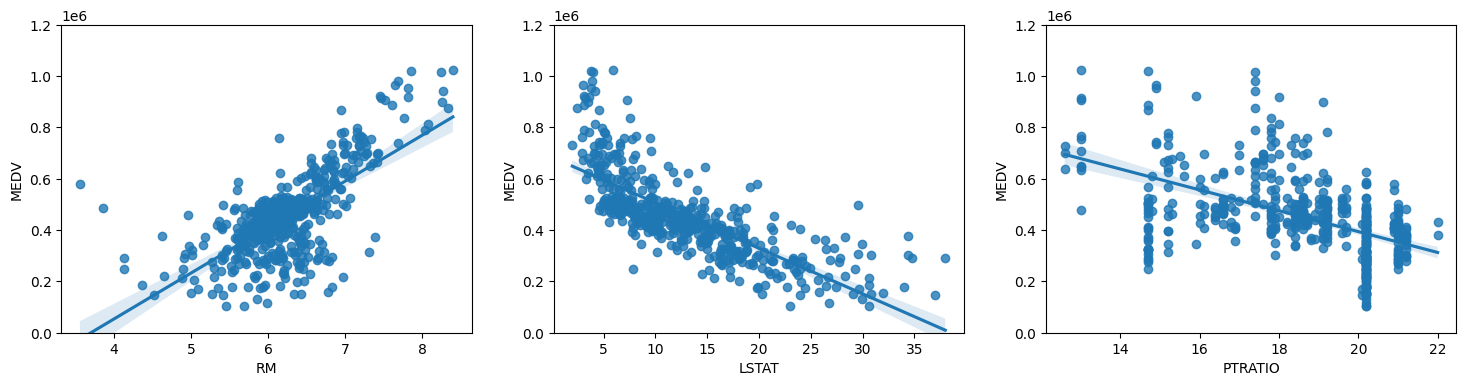

In [84]:
fig, axs = plt.subplots(ncols=3, figsize=(18,4))

for i in range(len(axs)):
    axs[i].set_ylim([0, 1200000])
# RM vs Price
_ = sns.regplot(x=features['RM'], y=prices, ax=axs[0])
# LSSAT vs Price
_ = sns.regplot(x=features['LSTAT'], y=prices, ax=axs[1])
# PTRATIO vs Price
_ = sns.regplot(x=features['PTRATIO'], y=prices, ax=axs[2])

plt.show()

## 모델 개발 및 생성

### 모델 성능 평가 지표

- 모델의 성능을 평하기 위해서는 train/test 데이터셋에서의 모델 성능을 정량화하는 지표가 필요하다.
- 이러한 지표는 일반적으로 오류 계산, 적합도, 다른 측정값 등을 통해 계산된다.
- 현재 이 프로젝트에서는 모델 성능 정량화를 위해 R2(결정 계수)를 계산할 것이다.
- R2 는 회귀 분석에서 모델 예측의 정확도를 나타내는 유요한 지표이다.

#### R2

- R2 값의 범위는 0에서 1 사이이며, 예측 값과 실제 값 사이의 제곱 상관 계수의 비율을 나타낸다.
- 즉 R2 값이 1인 모델은 완벽하게 타깃 변수를 예측하는 모델이라고 할 수 있다.
- 모델은 또한 음의 R2 값을 가질 수도 있습니다. 이는 모델이 항상 타깃 변수의 평균값을 예측하는 것보다 더 나쁜 성능을 가진다는 것을 의미합니다.

In [85]:
# performance_metric 함수 구현

# y_true: 실제 값 (타깃 변수) 벡터입니다.
# y_predict: 예측 값 벡터입니다.
def performance_metric(y_true, y_predict):

    # sklearn.metrics 에서 r2_score 를 사용하여 y_true 와 y_predict 사이의 성능을 계산합니다. 
    score = r2_score(y_true, y_predict)
    
    # 계산된 성능 점수를 score 변수에 할당한다.
    return score

### 예시를 통한 예측, 결정계수 값의 확인

데이터 세트에 다섯 개의 데이터 포인트가 있고, 모델이 타깃 변수에 대한 다음과 같은 예측값을 생성했다고 가정해보자

| 실제 값 | 예측 값 |
|---|---|
| 3.0 | 2.5 |
| -0.5 | 0.0 |
| 2.0 | 2.1 |
| 7.0 | 7.8 |
| 4.2 | 5.3 |

코드 실행을 통해 `performance_metric` 함수를 사용하여 이 모델의 결정 계수 (R2)를 계산하면

**코드 실행으로 결정 계수 계산**

1. 위 코드를 실행하면 실제값 (`y_true`)과 예측값 (`y_predict`)을 함수에 입력값으로 전달합니다.
2. `performance_metric` 함수는 `sklearn.metrics` 에서 褌r2_score` 함수를 사용하여 실제 값과 예측 값 사이의 결정 계수 (R2)를 계산합니다.
3. 계산된 결정 계수 값은 코드 실행 결과로 출력됩니다.

**결정 계수 (R2) 해석**

결정 계수 (R2)은 0에서 1 사이의 값을 가지며, 예측값과 실제 값 사이의 일치 정도를 나타냅니다.

* R2값이 0에 가까운 경우: 모델의 예측 성능이 좋지 않습니다.
* R2값이 1에 가까운 경우: 모델의 예측 성능이 우수합니다.

따라서 결정 계수 값을 통해 모델의 적합도를 평가할 수 있습니다.

In [86]:
# 모델의 R2 값을 계산하자
score = performance_metric([3, -0.5, 2, 7, 4.2], [2.5, 0.0, 2.1, 7.8, 5.3])
print("Model has a coefficient of determination, R^2, of {:.3f}.".format(score))

Model has a coefficient of determination, R^2, of 0.923.


### 적합도 분석의 결론

- 과연 이 모델은 타깃 변수의 변화를 성공적으로 예측했다고 생각하는가?

- 데이터 분석의 결과 : 코드를 실행하여 얻은 R2 값을 활용하여 모델의 적합도를 평가할 수 있습니다.
    
    예시 데이터의 경우 R2 값이 0.923에 가까운 값으로 나왔다고 가정합니다.

- 즉 따라서 R2 값이 0.923에 가까운 값은 모델이 대부분의 데이터 포인트에서 실제 값과 예측 값 사이에 높은 일치도를 보여준다는 것을 의미한다.


### 모델 평가

- 코드 실행 결과 예시에서 볼 수 있듯이 예측 값과 실제 값이 서로 가까운 것을 확인할 수 있습니다. 
- 또한 R2 값이 0.923에 가까운 높은 값을 가지고 있기 때문에 이 모델은 타깃 변수의 변화를 성공적으로 예측했다고 판단할 수 있다.

#### 추가 설명

- R2 값이 1에 완전히 근접하지는 않았지만 0.9 이상의 높은 값을 가지고 있어 대부분의 경우 좋은 성능을 보였다고 평가할 수 있습니다.

- 하지만 실제 데이터를 사용한 모델 평가에서는 더 많은 데이터를 사용하여 일반화 성능을 검증하는 것이 중요합니다.

## 데이터 분리와 무작위 추출

- 보스톤 주택 가격 데이터셋을 train/test 로 분리하는 작업을 실시
- 이는 데이터 분할 시에는 데이터 순서에 따른 편향을 제거하기 위해 데이터를 셔플링하는 것이 일반적입니다.

### ttrain_test_split 함수를 사용, 데이터 분할

- sklearn.model_selection 에서 train_test_split 함수를 사용하여 특징 데이터 (X)와 가격 데이터 (y)를 셔플링하고 train/test 로 분할합니다.

- 데이터 분할 비율은 train 80%, test 20% 설정

- train_test_split 함수의 random_state 파라미터에 원하는 정수값을 입력함. 이는 코드 실행 결과의 재현 가능성을 높이기 위해 사용되며, 특정 값을 고정하여 실행하면 동일한 분할 결과를 얻을 수 있기 때문임

- 분할된 데이터는 X_train, X_test, y_train, y_test 변수에 각각 할당한다.

In [87]:
# 데이터 분리, 변수 할당을 train_test_split 을 활용에 적용
X_train, X_test, y_train, y_test = train_test_split(features, prices, test_size=0.2, random_state=0)

# 성공 메시지 출력
print("Training and testing split was successful.")

Training and testing split was successful.


### 훈련 데이터와 테스트 데이터 분리의 장점

- 질문: 학습 알고리즘을 위해 데이터셋을 train/test 비율로 분할했을 때의 이점은 무엇입니까?

**데이터 분할 이유**

- 데이터 분할의 이유는 `과소적합(Underfitting)`과 `과대적합(Overfitting)`을 방지하기 위해서 입니다.
* 실제 상황에서는 보통 모든 데이터를 학습하는데 사용하지 않는다.
* 학습에 사용하는 데이터를 **훈련 데이터(Train)**라고 부르고, 학습된 모델의 성능을 평가하는데 사용하는 데이터를 **평가 데이터(Test)**라고 부릅니다.

**훈련 데이터와 테스트 데이터 분할 시 이점**

* **과소적합(Underfitting) 방지**

    - 모델이 너무 단순하여 데이터의 패턴을 충분히 학습하지 못하는 경우를 과소적합이라고 한다.
    - 이런 경우 테스트 데이터에 대한 예측 성능이 떨어집니다.
    - 훈련 데이터와 테스트 데이터를 분리하여 모델을 훈련 시에는 훈련 데이터에 과도하게 맞추지 않고 일반적인 패턴을 학습하도록 유도합니다.

* **과대적합(Overfitting) 방지**

    - 모델이 훈련 데이터에 너무 세세한 패턴까지 학습하여 훈련 데이터에는 높은 성능을 보이지만 테스트 데이터에 대한 예측 성능이 떨어지는 경우를 과대적합이라고 합니다.
    - 훈련 데이터와 테스트 데이터를 분리하여 모델을 평가함으로써 과대적합을 방지할 수 있습니다.

**결론**:

- 데이터 분할을 통해 훈련 데이터로 모델을 학습하고 테스트 데이터로 모델의 일반화 성능을 평가하여 과소적합과 과대적합을 방지할 수 있습니다.


## 모델 성능 분석

**모델 성능 분석 방법**

* **다양한 모델 비교**: 여러 모델을 선택하여 train/test 에서 각 모델의 학습 및 테스트 성능을 비교합니다. 이를 통해 어떤 모델이 새로운 데이터에 대해 일반화 성능이 우수한지 확인할 수 있습니다.

* **훈련 데이터 크기 변화**: 훈련 데이터의 크기를 변화시키면서 모델의 성능 변화를 관찰합니다. 훈련 데이터 크기가 증가할 때 모델 성능이 어떻게 변하는지 분석하여 과소적합 또는 과대적합 문제를 파악할 수 있습니다.

* **모델 복잡도**: 모델의 복잡도를 변화시키면서 성능 변화를 관찰합니다. 모델 복잡도가 증가할 때 과대적합 문제가 발생하는지 확인하고 최적의 모델 복잡도를 찾을 수 있습니다.

**모델 복잡도 변화 분석**
    
    - 'max_depth' 파라미터를 증가시키면서 모델 성능 변화를 분석합니다. 
    
    - 'max_depth' 파라미터는 결정 트리 모델의 복잡도를 조절하는 파라미터입니다. 
    
    - 'max_depth' 값이 높을수록 더 복잡한 모델이 생성됩니다.

### 학습 곡선

- 코드 실행 결과는 결정 트리 모델에 대한 네 개의 그래프를 생성합니다. 

- 각 그래프는 학습 데이터 세트의 크기를 증가시키면서 훈련 및 테스트 데이터에 대한 모델의 학습 곡선을 시각화합니다. 

- 학습 곡선의 그늘진 영역은 해당 곡선의 불확실성 (표준 편차)을 나타냅니다. 

- 모델은 결정 계수 (R2)를 사용하여 train/test 세트 모두에서 평가됩니다.

### 그렇다면 훈련 데이터 세트의 크기가 증가함에 따라 학습 곡선의 경향은 어떻게 변할까? 이는 과소적합 또는 과대적합과 어떤 관련이 있을까?

**학습 곡선 분석법 활용**:

- 그래프를 활용하여 훈련 데이터 크기가 증가함에 따라 모델의 성능 변화를 파악할 수 있습니다. 특히, 과소적합과 과대적합 문제를 진단하는데 도움이 됩니다.

**분석 예시**:

* 일반적으로 훈련 데이터 크기가 증가함에 따라 훈련 데이터에 대한 모델의 성능(R2 값)은 점점 증가하는 경향을 보인다. 이는 모델이 더 많은 데이터를 학습하여 성능이 향상되기 때문입니다.

* 테스트 데이터에 대한 성능 (R2 값) 역시 초기에는 훈련 데이터 크기 증가와 함께 증가하지만, 어느 시점 이후부터는 더 이상 증가하지 않거나 오히려 감소하는 경우가 있는데, 이는 모델이 훈련 데이터에 과도하게 적합되어 (과대적합) 테스트 데이터에 대한 일반화 성능이 떨어지기 때문입니다.

**결론**:

* 학습 곡선을 통해 훈련 데이터 크기가 증가함에 따라 과소적합과 과대적합 문제를 진단할 수 있습니다. 

* 적절한 모델 복잡도와 훈련 데이터 크기를 선택하여 과소적합과 과대적합을 방지하는 것이 중요합니다.

c:\Users\gherwt\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\gherwt\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\gherwt\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\gherwt\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\gherwt\AppData\Local\Programs\Python\Python

c:\Users\gherwt\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\gherwt\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\gherwt\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\gherwt\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\gherwt\AppData\Local\Programs\Python\Python

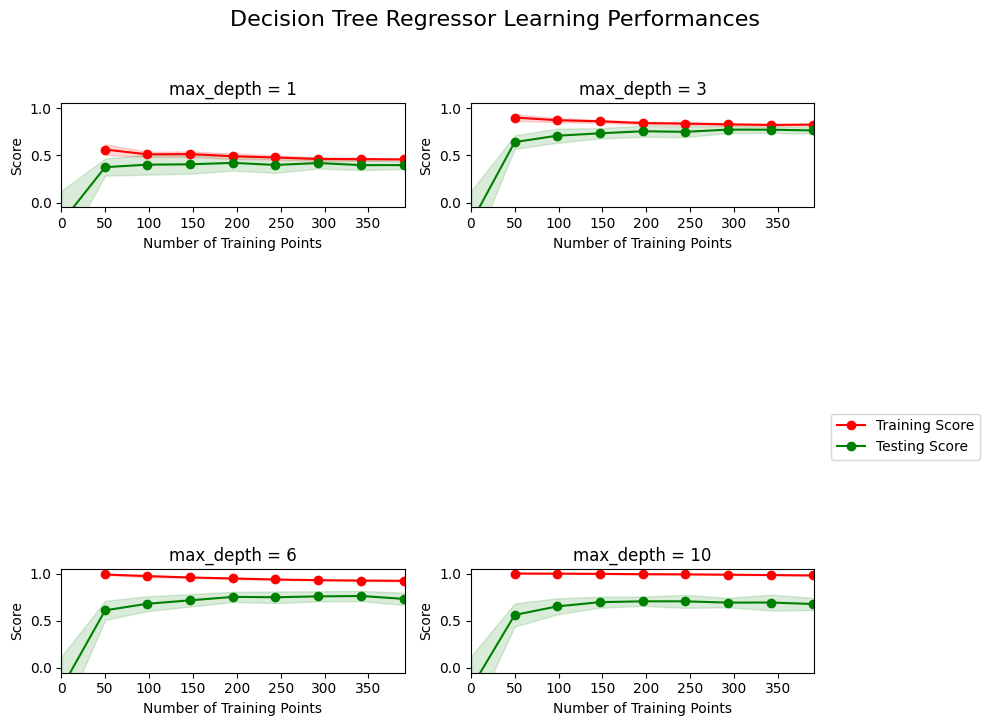

In [88]:
# train size 와 모델의 성능 간의 관계를 시각화
# 데이터 양이 증가함에 따라 모델이 어떻게 학습하는지, 최대 깊이가 모델 성능에 어떤 영향을 미치는지를 확인
ModelLearning(features, prices)

## 데이터 학습

위 그래프 중 하나를 선택하여 해당 결정 트리 모델의 'max_depth' 값을 확인해보자. 

- 그래프 1을 선택, 'max_depth' 값은 3

**훈련 데이터 크기 증가에 따른 학습 곡선 변화**

* train 데이터 크기를 늘려갈 때 훈련 데이터에 대한 모델 성능 (R2 값)은 어떻게 변화할까?

    - train 데이터 크기가 증가 -> train 데이터에 대한 모델 성능 (R2 값)도 함께 증가함. 이는 모델이 더 많은 데이터를 학습하여 성능이 향상되기 때문. 

* test 데이터에 대한 모델 성능 (R2 값)은 어떻게 변화할까?

    - 초기에는 train 데이터 크기 증가와 함께 test 데이터에 대한 성능 (R2 값)도 증가하지만, 어느 시점 이후부터는 더 이상 증가하지 않거나 오히려 감소하는 경향을 보입니다. 

    - 이는 모델이 훈련 데이터에 과도하게 적합되어 (과대적합) 테스트 데이터에 대한 일반화 성능이 떨어지기 때문입니다.

**추가 훈련 데이터의 이점**

* 훈련 데이터를 더 많이 사용하는 것이 모델 성능 향상에 도움이 될까?

    - 학습 곡선을 살펴보면 훈련 데이터와 테스트 데이터의 곡선이 이미 특정 수준의 값 (예를 들어 0.9 이상)으로 수렴하고 있는 경우, 추가적인 훈련 데이터를 사용하는 것은 반드시 필요하지sms 않다. 

**학습 곡선 해석**

학습 곡선의 모양을 보고 다음에 대해 고려해보자

* 학습 곡선은 특정값으로 수렴하고 있습니까?

    * 일반적으로 데이터가 많을수록 모델 성능은 향상된다. 하지만 훈련 데이터와 테스트 데이터의 곡선이 기준 스코어 이상의 값으로 수렴하고 있다면 더 많은 훈련 데이터를 사용하는 것은 반드시 필요할까라는 의문이 생김

**훈련 데이터 크기 증가의 장단점**

train/test 데이터의 학습 곡선이 수렴하고 있는지 여부에 따라 추가적인 훈련 데이터 사용의 장단점을 고려할 수 있다.

**장점**

* 추가 데이터를 사용하면 모델의 성능이 더 향상될 수도 있지만, 실질적인 성능 향상은 미미할 수 있습니다.
* 데이터 수집 및 전처리 과정에 시간과 리소스가 소요될 수 있습니다.

**단점**

* 추가 데이터를 사용하지 않으면 모델 성능이 향상되지 않을 수도 있습니다.
* 특히 데이터 자체가 부족한 경우 추가 데이터 확보는 중요합니다.

**결론**

현재 모델의 성능이 기준을 충족하고 있으며, 추가 데이터 수집에 드는 비용 대비 이익이 적다고 판단된다면 추가 훈련 데이터를 사용하지 않아도 된다. 하지만 데이터 자체가 부족하거나 성능 향상 여지가 있다고 판단된다면 추가 데이터 확보를 고려해볼 수 있다. 


## 학습 곡선 분석/해석

**각 학습 곡선별 결정 트리 모델의 최대 depth**

* 학습 곡선 1: 최대 depth = 1
* 학습 곡선 2: 최대 depth = 3
* 학습 곡선 3: 최대 depth = 6
* 학습 곡선 4: 최대 depth = 10

**훈련 데이터 크기 증가에 따른 학습 곡선 변화**

각 학습 곡선마다 훈련 데이터 크기가 증가함에 따라 훈련 데이터와 테스트 데이터 
에 대한 모델 성능 (R2 값)의 변화를 분석.

* **학습 곡선 1**

    * 과소적합

    * 훈련 데이터 크기가 증가해도 훈련 스코어는 약 0.5 정도로 유지되고, 테스트 스코어도 비슷한 수준임.

    * 추가적인 훈련 데이터는 모델 성능 향상에 도움이 되지 않습니다.
    
    * 오히려 모델 복잡도를 높여 데이터의 일반적인 패턴을 학습하도록 유도하는 것이 필요.

* **학습 곡선 2**

    * 우수한 성능을 보임.

    * 훈련 스코어와 테스트 스코어 모두 약 0.8 수준으로 수렴한다.

    * 추가적인 훈련 데이터를 사용하면 모델 성능이 더 향상될 수도 있지만 실질적인 이익은 미미할 수 있다.

* **학습 곡선 3**

    * 약간 과대적합

    * 훈련 스코어는 0.9 수준으로 수렴하고, 테스트 스코어는 0.75 수준으로 수렴한다.

    * 추가적인 훈련 데이터는 오히려 과대적합 문제를 악화시킬 수 있다.

    * 모델 복잡도를 낮추어 과대적합을 방지하는 것이 필요
    
* **학습 곡선 4**

    * 심각한 과대적합을 보임.

    * 훈련 스코어는 1에 매우 가까운 값으로 수렴하고, 테스트 스코어는 0.6 수준 으로 수렴합니다.

    * 추가적인 훈련 데이터는 오히려 과대적합 문제를 악화시킬 수 있다.

    * 모델 복잡도를 낮추어 과대적합을 방지하는 것이 필요

**결론**

학습 곡선을 통해 훈련 데이터 크기가 증가함에 따라 과소적합, 적절한 모델 복잡도, 과대적합 여부를 진단할 수 있다. 적절한 모델 복잡도를 선택하고 필요한 경우에만 추가적인 훈련 데이터를 사용하여 모델 성능을 향상시킬 수 있다.


## 모델 복잡도 곡선 분석


**모델 복잡도 곡선**:

* 학습 곡선과 유사하게 모델 복잡도 곡선은 두 개의 곡선으로 구성한다.
    * 훈련 데이터에 대한 곡선 (training curve)
    * 검증 데이터에 대한 곡선 (validation curve)

* 훈련 데이터에 대한 곡선은 모델의 최대 depth가 증가함에 따라 모델 복잡도가 증가함을 보인다. 일반적으로 결정 트리 모델에서 최대 depth가 증가할수록 더 많은 분기 조건을 사용하여 데이터를 더 세세하게 분할하기 때문에 모델 복잡도가 증가한다.

* 검증 데이터에 대한 곡선은 모델의 예측 성능을 나타낸다. 최대 depth가 증가함에 따라 과소적합 또는 과대적합 문제가 발생할 수 있으며, 이는 검증 데이터에 대한 성능 변화로 나타납니다.

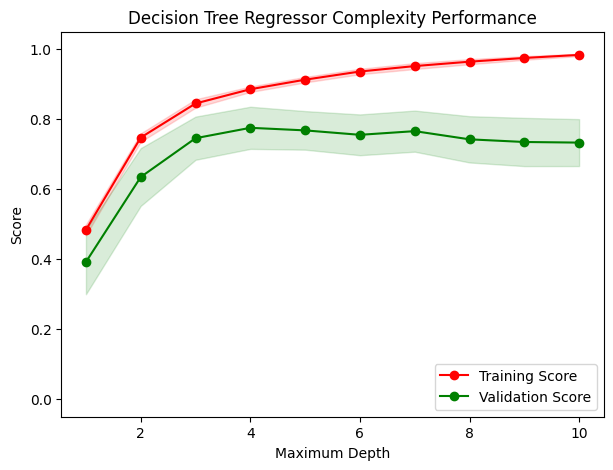

In [89]:
# 결정 트리 모델에 대한 모델 복잡도 곡선을 생성
ModelComplexity(X_train, y_train)

## 과소적합과 과대적합의 척도

**모델 복잡도(max_depth)에 따른 편향(Bias)과 분산(Variance) 분석**

그래프를 이용하여 최대 depth가 1과 10일 때 모델의 과소적합 또는 과대적합 여부를 판단해보자

* 높은 편향은 과소적합 (Underfitting)을 의미 (데이터의 핵심적인 패턴을 학습하지 못하는 단순한 모델)

* 높은 분산은 과대적합 (Overfitting)을 의미 (일반화 성능이 떨어지는 복잡한 모델)

**분석**

* **최대 depth=1**

    * 이 경우 모델은 데이터로부터 거의 정보를 학습하지 못하고 높은 **편향**을 가진다.

    * 데이터의 변화 (분산)을 학습하지 못하며 일반적인 패턴을 추출하지 못합니다.

    * 이러한 경우 과소적합 모델이 생성되며 모델 복잡도를 높여야 합니다. (예를 들어, 최대 depth=5를 사용)

* **최대 depth=10**

    * 이 경우 모델은 데이터의 모든 정보를 학습하려고 시도하며 높은 **분산**을 갖는다.

    * 모델은 데이터를 일반화하지 못하고 데이터의 모든 세부 사항과 불필요한 부분까지 학습합니다.

    * 이러한 경우 과대적합 모델이 생성되며 모델 복잡도를 낮추어야 한다. (예를 들어, 최대 depth=5를 사용)

**결론**

* **과소적합**: 훈련 데이터 스코어와 검증 데이터 스코어 모두 매우 낮은 경우 - max depth=1일 때 

* **과대적합**: 훈련 데이터 스코어와 검증 데이터 스코어가 모두 매우 높지만 서로 크게 차이 나는 경우 - max depth=10일 때

* **적절한 모델**: 훈련 데이터 스코어와 검증 데이터 스코어가 모두 높고 서로 유사한 경우 - max depth=4 일 때

## 최적 모델 선택

**최적의 일반화 성능을 보이는 모델 선택**

일반화 성능이 가장 우수한 모델의 'max_depth' 값을 결정

**가이드**

* Occam's Razor:  문제를 해결하는 데 있어 가장 단순한 해결 방법이 보통 가장 정확하다는 가정

* 그래프에서 검증 데이터 스코어를 확인하여 모델의 복잡도 (max_depth)가 증가함에 따른 성능 변화를 분석

* 일반적으로 모델 복잡도가 증가할수록 검증 데이터 스코어도 향상될 수 있지만 어느 시점 이후부터는 과대적합 문제가 발생하여 성능이 저하될 수 있다.

**분석**

* 그래프를 보면 max depth=3일 때 검증 데이터 스코어가 약 0.75 이며 훈련 데이터 스코어는 0.85 정도이다. 

* 이는 모델이 데이터를 적절히 학습하고 일반화 성능이 우수하다는 것을 의미

* max depth=4도 검증 데이터 스코어가 0.8 정도로 비슷한 성능을 보이지만, 훈련 데이터 스코어와의 차이가 더 커져 약간의 과대적합 경향을 보임.

**결론**

* 따라서 최적의 일반화 성능을 위해서는 모델의 복잡도를 높이면서도 과대적합을 최소화해야 함

* Occam's Razor의 가정에 따라 불필요하게 복잡한 모델보다는 상대적으로 단순하면서, 검증 데이터 성능이 우수한 모델을 선택하는 것이 좋습니다.

* 최적의 모델은 'max_depth=3'인 모델 

## 그리드 검색 기법

- 그리드 검색은 알고리즘의 하이퍼 파라미터를 튜닝하여 최적의 모델을 생성하는 시스템적인 기법입니다.

* **하이퍼 파라미터**: 머신 러닝에서 학습 과정을 시작하기 전에 설정하는 파라미터입니다. (예: 회귀 모델의 다항식 차수)

* **모델 파라미터**: 학습 과정을 통해 결정되는 파라미터입니다. (예: 회귀 모델의 다항식 계수)

**그리드 검색 활용 방법**

- 그리드 검색은 알고리즘의 하이퍼 파라미터 공간에서 사용자가 지정한 하위 집합을 시스템적으로 탐색하여 하이퍼 파라미터를 최적화함

* **탐색 과정**

    * 그리드 검색은 사용자가 정의한 하이퍼 파라미터 값들의 조합을 모두 탐색.

    * 예를 들어, 하이퍼 파라미터 두 개 ('max_depth'와 'max_features')가 있다고 가정하면 그리드 검색은 각 하이퍼 파라미터에 대해 정의된 값들의 모든 조합을 시도함.

* **성능 평가**

    * 그리드 검색은 교차 검증 (cross-validation) 또는 보유한 검증 세트를 이용하여 모델 성능을 평가한다.

    * 성능 평가 지표를 통해 최적의 하이퍼 파라미터 조합을 선택

**예시**

- DecisionTreeRegressor()를 사용하는 경우 다음과 같은 하이퍼 파라미터를 그리드 검색에 적용하여 최적의 조합을 찾을 수 있습니다.

```python
params = {'max_depth': [2,3,4], 'max_features':['auto', 'sqrt', 'log2']}
```

- 그리드 검색은 위의 하이퍼 파라미터 조합 모두를 시도하며 모델을 생성한 후 교차 검증 점수를 사용하여 최적의 하이퍼 파라미터 세트를 선택함.

**결론**

- 그리드 검색은 시스템적인 방법으로 하이퍼 파라미터를 탐색하여 모델 성능을 향상시키는 데 효과적인 기법이지만 그리드 검색은 모든 하이퍼 파라미터 조합을 탐색하기 때문에 시간과 계산 자원 소모가 클 수 있다. 따라서 효율적인 그리드 검색을 위해서는 탐색할 하이퍼 파라미터의 범위를 적절하게 설정하는 것이 중요함.


## 교차검증

### **k-fold 교차검증**

k-fold 교차검증은 기존의 train/test 데이터의 분할 방식을 개선한 기법이다. 

* 기존 방식은 전체 데이터를 훈련 데이터와 검증 데이터 세트로 나누어 모델을 학습 및 평가하는 방법이었는데, 이 방법은 전체 데이터량이 적을 경우 학습에 사용되는 데이터가 부족해져 모델 성능 향상에 한계가 있다.

* 하지만 k-fold 교차검증에서 k개의 층은 서로 독립적이며 크기가 거의 같은 파티션으로 데이터를 분할한다.

* k개의 층 중 하나를 검증 데이터로 사용하고 나머지 k-1개의 층을 훈련 데이터로 사용하여 모델을 학습 및 평가한다.

* 이 과정을 k번 반복하여 모든 층이 한 번씩 검증 데이터로 사용되도록 합니다.

* 각 층에 대한 평가 지표를 평균하여 모델 성능을 추정합니다.

**그리드 검색과 k-fold 교차검증**

- 그리드 검색은 하이퍼 파라미터를 최적화하는 알고리즘지만 특정 데이터 분할에 의존하기 때문에 과소적합 또는 과대적합 문제가 발생할 수 있다. 

k-fold 교차검증을 함께 사용하면 이러한 문제를 완화할 수 있다.

* k-fold 교차검증을 통해 각 하이퍼 파라미터 조합에 대한 평균 성능을 얻을 수 있습니다.

* 이를 통해 더욱 일반화 가능한 하이퍼 파라미터 조합을 선택할 수 있다.

**결론**

k-fold 교차검증은 그리드 검색과 함께 사용하여 모델 성능을 향상시키는 데 효과적인 기법이다. k-fold 교차검증을 통해 각 하이퍼 파라미터 조합에 대한 평균 성능을 평가하여 과소적합 또는 과대적합을 최소화하고 일반화 성능이 우수한 모델을 생성할 수 있다.

## 최적화된 결정 나무 모델을 생성하자

##  최적화된 결정 트리 모델 생성

사용자 정의 함수 `fit_model`에서는 그리드 검색 기법을 활용, 결정 트리 모델을 최적화한다.

**그리드 검색 설정**

* 알고리즘: `sklearn.tree.DecisionTreeRegressor` (결정 트리 회귀)

* 최적화 파라미터: `max_depth` (트리의 최대 깊이)
    * 트리의 최대 깊이란 결정 트리가 데이터에 대해 질문할 수 있는 최대 질문 횟수를 의미.

* 하이퍼 파라미터 범위: 1 ~ 10

* 성능 평가 지표: `performance_metric` 함수 (사용자 정의 함수)

* 교차 검증: `ShuffleSplit()`

**ShuffleSplit() 교차 검증**

    * ShuffleSplit()은 K-fold 교차 검증과 유사한 교차 검증 기법이다. 

    * ShuffleSplit()은 데이터를 무작위로 섞은 후 지정된 비율로 훈련 데이터와 검증 데이터를 반복적으로 분할한다.

In [90]:
def fit_model(X, y):

    # 데이터를 무작위로 추출하고 train/test 로 분리한다.
    cv_sets = ShuffleSplit(n_splits = 10, test_size = 0.20, random_state = 0)
    cv_sets.get_n_splits(X)

    # sklearn.tree.DecisionTreeRegressor를 사용하여 결정 트리 회귀 객체(regressor) 생성
    regressor = DecisionTreeRegressor(random_state=0)

    # max_depth 파라미터에 대한 값 1 ~ 10을 params 딕셔너리로 생성 
    params = {'max_depth':range(1,11)}

    # make_scorer를 사용하여 성능 평가 지표 객체 생성
    # performance_metric 함수를 사용해 파라미터로 전달
    scoring_fnc = make_scorer(performance_metric)

    # GridSearchCV를 사용하여 그리드 검색 객체 생성
    # 파라미터로 regressor, params, scoring_fnc, cv_sets 를 전달
    grid = GridSearchCV(regressor, params, scoring=scoring_fnc, cv=cv_sets)

    # grid 모델을 최종으로 생성하고 학습시킨다.
    grid = grid.fit(X, y)

    return grid

In [91]:
# 그리드 검색을 사용하여 훈련 데이터를 모델에 맞춤
# fit_model 함수를 사용하여 모델 학습
reg = fit_model(X_train, y_train)

# max_depth 구한다.
print("최적 모델의 'max_depth' 파라미터 값은 {}입니다.".format(reg.best_estimator_.get_params()['max_depth']))
print("Best Score is {:.2f}".format(reg.best_score_))

최적 모델의 'max_depth' 파라미터 값은 4입니다.
Best Score is 0.78


**최적 하이퍼파라미터: max_depth**

- 코드 실행 결과 'max_depth' 값이 4일 때 최적 성능 (0.78) 이다. 흥미롭게도 'max_depth' 값이 3일 때도 비슷한 성능 (0.75)을 보임.

**해석**

* 이 결과는 'max_depth' 값이 3과 4 모두 모델 성능 향상에 효과적이라는 것을 나타냄

* 하지만 코드 실행 결과를 바탕으로 볼 때 'max_depth'값을 4로 설정하는 것이 약간 더 나은 성능을 기대할 수 있다.

**결론**

그리드 검색을 통해 결정 트리 모델의 하이퍼파라미터 'max_depth' 값을 최적화했고 'max_depth' 값은 4일 때 0.78의 성능을 달성하여 모델 학습에 효과적이었다.

##  모델 예측 및 가격 제안

보스톤 지역 부동산 중개업체가 클라이언트의 주택 가격을 예측하는 모델을 사용하고 있다고 가정해보자. 

세 명의 클라이언트로부터 다음과 같은 정보를 수집했다.

| 기능 | 클라이언트 1 | 클라이언트 2 | 클라이언트 3 |
|---|---|---|---|
| 주거실 총 개수 | 5 | 4 | 8 |
| 지역 빈곤 수준 (%) | 17 | 32 | 3 |
| 인근 학교의 학생-교사 비율 | 15 대 1 | 22 대 1 | 12 대 1 |

**예측 및 가격 제안**

* 수집된 정보를 기반으로 각 클라이언트의 주택 가격을 예측하고 코드 실행 결과를 통해 예측된 가격을 확인하여 클라이언트에 제안할 가격을 결정.

* 예측된 가격의 합리성 검토

    * 데이터 탐색에서 계산한 통계 자료를 활용하여 예측 가격의 합리성을 검토합니다.

    * 세 클라이언트 중 클라이언트 3은 가장 큰 집을 가지고 있으며 빈곤 수준이 가장 낮고 최고의 학군에 위치하고 있습니다. 반면에 클라이언트 2는 가장 작은 집을 가지고 있으며 빈곤 수준이 상대적으로 높은 지역에 위치하고 있습니다.

**코드 실행**
코드 블록을 실행하여 최적화된 모델이 각 클라이언트의 주택 가격을 예측해보자.


In [92]:
# 보스턴 지역의 집값의 데이터/통계 분석
with pd.option_context('float_format', '{:.2f}'.format):
    print(prices.describe())

count       489.00
mean     454342.94
std      165340.28
min      105000.00
25%      350700.00
50%      438900.00
75%      518700.00
max     1024800.00
Name: MEDV, dtype: float64


In [93]:
# 각 특성들의 데이터/통계 분석
with pd.option_context('float_format', '{:.2f}'.format):
    print(features.describe())

          RM  LSTAT  PTRATIO
count 489.00 489.00   489.00
mean    6.24  12.94    18.52
std     0.64   7.08     2.11
min     3.56   1.98    12.60
25%     5.88   7.37    17.40
50%     6.18  11.69    19.10
75%     6.58  17.12    20.20
max     8.40  37.97    22.00


## 각 클라이언트의 주택 가격 제안 및 예측 가격 합리성 분석 - 통계 분석만을 사용

**가격 제안**

통계 정보를 기반으로 각 클라이언트의 주택 가격을 다음과 같이 제안할 수 있다.

* 1번 클라이언트: 평균 가격 (454,342 달러 ±  표준 편차의 0.5배) 근처의 가격을 제안.

* 2번 클라이언트: 최소 가격 (150,000 달러 ± 표준 편차의 0.5배)보다 약간 높은 가격을 제안.

* 3번 클라이언트: 최대 가격 (900,000 달러 ± 표준 편차의 0.5배) 근처의 가격을 제안. 

**예측 가격의 합리성 분석**

- 합리적인가? 괜찮은 것으로 보인다.

* 이유는?

    * 2번 클라이언트의 경우 주거실 개수가 4개뿐이며, 지역 빈곤 수준이 높고 학생-교사 비율 (PTRATIO)도 높은데 이는 주택 가치가 낮음을 의미합니다.

    * 반면에 3번 클라이언트의 경우 주거실 개수가 8개이며, 지역 빈곤 수준이 매우 낮고 학생-교사 비율 (PTRATIO)도 매우 낮은데 이는 주택 가치가 높음을 의미합니다.

따라서 수집된 특징 값들을 기반으로 예측된 가격대는 합리적이며, 이를 토대로 클라이언트에게 주택 가격을 제안하는 것이 좋다. 

하지만 실제 시장 가격은 여러 다른 요인에 의해 영향을 받을 수 있으므로, 최종적인 가격 결정 전에는 시장 조사 및 부동산 전문가와의 상담을 통해 정확한 가격을 설정하는 것이 중요하다.


In [94]:
# 고객 데이터로 matrix 만들기
client_data = [[5, 17, 15], # 고객 1
               [4, 32, 22], # 고객 2
               [8, 3, 12]]  # 고객 3

# 예측 후 결과 도출하기
for i, price in enumerate(reg.predict(client_data)):
    print("고객 {} 의 예측 집 값은: ${:,.2f}".format(i+1, price))

고객 1 의 예측 집 값은: $391,183.33
고객 2 의 예측 집 값은: $189,123.53
고객 3 의 예측 집 값은: $942,666.67


c:\Users\gherwt\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


## 각 클라이언트의 주택 가격 제안 및 예측 가격 합리성 분석 - 모델 예측 결과를 사용

**가격 제안**

모델 예측 결과를 기반으로 각 클라이언트의 주택 가격을 다음과 같이 제안할 수 있습니다.

* 1번 클라이언트: 모델 예측 가격 (약 410,000 달러)을 중심으로 약 20,000 달러 정도의 여유폭을 두어 **350,000 달러 ~ 430,000 달러** 사이의 가격을 제안합니다. 
* 2번 클라이언트: 모델 예측 가격 (약 190,000 달러)을 중심으로 약 30,000 달러 정도의 여유폭을 두어 **160,000 달러 ~ 220,000 달러** 사이의 가격을 제안합니다.
* 3번 클라이언트: 모델 예측 가격 (약 940,000 달러)을 중심으로 약 35,000 달러 정도의 여유폭을 두어 **910,000 달러 ~ 980,000 달러** 사이의 가격을 제안합니다.

**예측 가격의 합리성 분석**

합리적인가? 합리적인 것처럼 보임 

* 이유?

    * 2번 클라이언트의 경우 주거실 개수가 4개뿐이며, 지역 빈곤 수준이 높고 학생-교사 비율도 높은데 이는 주택 가치가 낮음을 의미합니다. 따라서 예측 가격 (약 190,000 달러)을 기반으로 약간 높은 가격대를 제안

    * 반면에 3번 클라이언트의 경우 주거실 개수가 8개이며, 지역 빈곤 수준이 매우 낮고 학생-교사 비율도 매우 낮은데 이는 주택 가치가 높음을 의미합니다. 따라서 예측 가격 (약 940,000 달러)을 기반으로 약간 높은 가격대를 제안

    * 1번 클라이언트의 경우 다른 두 클라이언트에 비해 특징 값들이 평균에 가깝기 때문에 예측 가격 (약 410,000 달러)을 중심으로 가격대를 제안.

**제안 시 고려사항**

* 모델의 예측 정확도는 약 80%라고 언급되어 있지만, 여전히 오차가 존재할 수 있다. 
* 실제 시장 가격은 여러 다른 요인에 의해 영향을 받을 수 있다.

**결론**

모델 예측 결과를 기반으로 각 클라이언트에게 주택 가격을 제안했으며, 해당 가격대는 클라이언트가 보유한 주택 특징 값들과 합리적으로 일치하지만 실제 시장 상황을 반영하기 위해 추가적인 시장 조사 및 전문가 의견을 참고하는 것이 좋다.


## 민감도 (Sensitivity)

최적의 모델이 반드시 좋은 모델은 아니다. 때때로 모델은 너무 복잡하거나 너무 단순하여 새로운 데이터에 일반화하는 데 충분하지 않기도 한다. 또한 데이터의 구조에 적합하지 않은 학습 알고리즘을 사용하는 경우도 있을 수 있다. 또 데이터 자체가 너무 많은 잡음을 포함하거나 샘플이 너무 적어 모델이 목표 변수를 적절하게 캡처하지 못할 수도 있다.

**민감도 분석**

`fit_model` 함수를 서로 다른 훈련 데이터 및 테스트 데이터 세트로 10회 실행하면 특정 클라이언트에 대한 예측값이 훈련 데이터에 따라 어떻게 변하는지 확인할 수 있다.

**핵심 Point**

* 민감도 분석은 모델의 예측 결과가 훈련 데이터에 얼마나 민감한지 측정하는 데 도움이 된다.

* 모델 예측 결과가 훈련 데이터에 따라 크게 변동한다면 이는 모델이 과소적합 되었거나 Noise에 민감하다는 것을 의미

* 민감도 분석을 통해 모델의 일반화 성능을 평가하고 개선 여부를 파악할 수 있다. 

In [95]:
PredictTrials(features, prices, fit_model, client_data)

c:\Users\gherwt\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


Trial 1: $391,183.33


c:\Users\gherwt\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


Trial 2: $424,935.00


c:\Users\gherwt\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


Trial 3: $415,800.00


c:\Users\gherwt\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


Trial 4: $420,622.22


c:\Users\gherwt\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


Trial 5: $418,377.27


c:\Users\gherwt\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


Trial 6: $411,931.58


c:\Users\gherwt\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


Trial 7: $399,663.16


c:\Users\gherwt\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


Trial 8: $407,232.00


c:\Users\gherwt\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


Trial 9: $351,577.61
Trial 10: $413,700.00

Range in prices: $73,357.39


c:\Users\gherwt\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


## 모델의 실제 세계 적용 가능성

**한계점**

1978년도 데이터 사용

* 1978년도에 수집된 데이터는 현재 시장 상황을 반영하지 못할 수 있습니다. 

* 물가 상승률을 고려하더라도 데이터 자체가 오래되었기 때문에 가격 예측의 정확성에 영향을 미칠 수 있다.

특징 값의 한계

* 현재 모델은 주거실 개수, 지역 빈곤 수준, 학생-교사 비율만을 고려함. 
* 실제 주택 가격은 건물 유형, 건축 품질, 건축 연도, 욕실 개수, 주방 상태, 차고 여부, 수영장 여부, 울타리 여부 등 더 많은 요인에 의해 영향을 받는다. 때문에 이러한 추가적인 특징 값들을 사용하면 모델의 예측 정확도를 높일 수 있다.

모델의 견고성

* 제한된 특징 값과 데이터 샘플로 학습된 모델은 좋지 않을 수 있다.

* 따라서 모델 예측 결과만 의존하지 않고 시장 상황 및 부동산 전문가 의견 등을 종합적으로 고려하는 것이 중요합니다.

모델의 일반화 범위

* 보스턴 지역 데이터를 기반으로 구축된 모델은 보스턴 지역에서만 적용 가능

* 다른 도시는 서로 다른 주택 가격 범위를 가지고 있을 수 있기 때문에 해당 지역에 맞는 데이터를 사용하여 별도의 모델을 학습해야 합니다.

개별 주택 가격 판단

* 이웃의 특징만 고려하여 개별 주택 가격을 판단하는 것은 정확하지 않을 수 있다. 

* 주택 자체의 다양한 속성 (예: 건물 유형, 면적, 시설 상태 등)이 가격에 영향을 미치기 때문


**결론**

현재 모델은 여러 제약 사항으로 인해 실제 상황에 대한 정확한 예측을 보장하기 어렵다. 좀 더 정확하고 신뢰할 수 있는 예측을 위해서는 최신 데이터, 더 많은 특징 값, 그리고 보다 견고한 모델 학습이 필요함. 또한 특정 지역에서의 주택 가격 예측을 위해서는 해당 지역 데이터를 활용하여 별도의 모델을 개발하는 것이 좋다.
